In [ ]:
import zipfile
import os
import time
import shutil
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/drive/MyDrive/Reef Dataset'
path_train = os.path.join(base_dir, 'train')
path_val = os.path.join(base_dir, 'val')
#os.mkdir(path_train)
#os.mkdir(path_val)

In [ ]:
spesies = ['Acropora Cervicornis', 'Acropora Palmata','Colpophyllia Natans',
           'Diadema Antillarum','Diploria Strigosa','Gorgonians','Millepora Alcicornis',
           'Montastraea Cavernosa','Meandrina Meandrites','Montipora spp.',
           'Palythoas Palythoa','Sponge Fungus','Siderastrea Siderea','Tunicates']

In [ ]:
for name in spesies:
  new_folder_train = os.path.join(path_train,str(name))
  new_folder_val = os.path.join(path_val,str(name))
  os.mkdir(new_folder_train)
  os.mkdir(new_folder_val)

In [ ]:
os.path.join(path_train,'Tunicates','as.jpg')

'/content/drive/MyDrive/Reef Dataset/train/Tunicates/as.jpg'

In [ ]:
for name in spesies:
  train, val = train_test_split(os.listdir(os.path.join(base_dir,name)), test_size = 0.3)

  for i in train:
    shutil.copy(os.path.join(base_dir,name,i), os.path.join(path_train,name,i))
  for i in val:
    shutil.copy(os.path.join(base_dir,name,i), os.path.join(path_val,name,i))

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 1

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size =(150,150),
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    path_val,
    target_size = (150,150),
    class_mode = 'categorical'
)

Found 762 images belonging to 14 classes.
Found 336 images belonging to 14 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = Xception(weights='imagenet', input_shape = (150,150,3),
                      include_top=False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- 18 classes
predictions = Dense(14, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
opt = Adam(lr=0.001, decay = 1e-6, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
#model.fit(train_generator, epochs=10, validation_data = validation_generator, verbose = 1)



83689472/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
    #print(i, layer.name)

# we chose to train the last inception blocks, i.e. we will freeze
# the first 125 layers and unfreeze the rest:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True
# we need to recompile the model for these modifications to take effect
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data = validation_generator, verbose = 1)

Epoch 1/10
24/24 [==============================] - 25s 856ms/step - loss: 0.8287 - accuracy: 0.7520 - val_loss: 2.6006 - val_accuracy: 0.5595
Epoch 2/10
24/24 [==============================] - 19s 786ms/step - loss: 0.4810 - accuracy: 0.8451 - val_loss: 2.8640 - val_accuracy: 0.6190
Epoch 3/10
24/24 [==============================] - 19s 771ms/step - loss: 0.2828 - accuracy: 0.9173 - val_loss: 1.8756 - val_accuracy: 0.6756
Epoch 4/10
24/24 [==============================] - 18s 777ms/step - loss: 0.2176 - accuracy: 0.9291 - val_loss: 2.1493 - val_accuracy: 0.6399
Epoch 5/10
24/24 [==============================] - 19s 786ms/step - loss: 0.1983 - accuracy: 0.9396 - val_loss: 1.3264 - val_accuracy: 0.7351
Epoch 6/10
24/24 [==============================] - 18s 775ms/step - loss: 0.1548 - accuracy: 0.9541 - val_loss: 1.0630 - val_accuracy: 0.7738
Epoch 7/10
24/24 [==============================] - 19s 776ms/step - loss: 0.1117 - accuracy: 0.9672 - val_loss: 1.2127 - val_accuracy: 0.7589

In [ ]:
model.save("model_xception_v2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


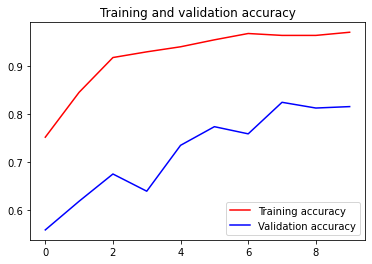

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
import tensorflow as tf

# Load the model.
new_model= tf.keras.models.load_model(filepath='/content/drive/MyDrive/model_xception_v2.h5')

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
labels = train_generator.class_indices.keys()
label = []
for a in labels:
  label.append(a)

Saving diploria-strigosa-a-brain-coral-on-a-coral-reef-in-the-maldives-EHXCH2 (1).jpg to diploria-strigosa-a-brain-coral-on-a-coral-reef-in-the-maldives-EHXCH2 (1).jpg


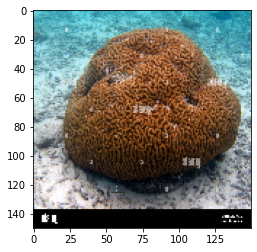

Acropora Cervicornis: 0.05%
Acropora Palmata: 0.00%
Colpophyllia Natans: 3.58%
Diadema Antillarum: 0.00%
Diploria Strigosa: 0.00%
Gorgonians: 0.01%
Meandrina Meandrites: 0.00%
Millepora Alcicornis: 0.02%
Montastraea Cavernosa: 94.23%
Montipora spp.: 0.02%
Palythoas Palythoa: 1.46%
Siderastrea Siderea: 0.62%
Sponge Fungus: 0.00%
Tunicates: 0.00%



In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  

  images = np.vstack([x])
  proba = new_model.predict(images)[0]
  max_index_row = np.argmax(proba)
  plt.imshow(img)
  plt.show()
  print("{}: {:.2f}%".format(label[max_index_row], proba[max_index_row] * 100))
  print('')

In [ ]:
import tensorflow as tf

# Load the model.
new_model= tf.keras.models.load_model(filepath='/content/model_xception_v2.h5')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model_xception_v2.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp2xau7kqd/assets


In [ ]:
!tensorflowjs_converter \
     --input_format=keras \
     model_xception_v2.h5 \
     model_js

2021-07-29 11:40:05.285110: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 2.7 MB/s 


In [ ]:
!zip -r /content/model.zip /content/model_js

  adding: content/model_js/ (stored 0%)
  adding: content/model_js/group1-shard4of21.bin (deflated 7%)
  adding: content/model_js/group1-shard6of21.bin (deflated 7%)
  adding: content/model_js/group1-shard14of21.bin (deflated 7%)
  adding: content/model_js/group1-shard16of21.bin (deflated 7%)
  adding: content/model_js/group1-shard1of21.bin (deflated 7%)
  adding: content/model_js/group1-shard11of21.bin (deflated 7%)
  adding: content/model_js/group1-shard19of21.bin (deflated 7%)
  adding: content/model_js/group1-shard18of21.bin (deflated 7%)
  adding: content/model_js/group1-shard21of21.bin (deflated 7%)
  adding: content/model_js/group1-shard2of21.bin (deflated 7%)
  adding: content/model_js/group1-shard17of21.bin (deflated 7%)
  adding: content/model_js/model.json (deflated 96%)
  adding: content/model_js/group1-shard9of21.bin (deflated 7%)
  adding: content/model_js/group1-shard3of21.bin (deflated 7%)
  adding: content/model_js/group1-shard10of21.bin (deflated 7%)
  adding: content

In [ ]:
files.download("/content/model.zip")